<a href="https://colab.research.google.com/github/revatishelat/DST_A2/blob/main/report/01_Introduction_EDA_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we investigate natural language processing as applied to the medical field.

We identified a dataset containing the abstracts of medical papers and articles, concerning various patient conditions. Each abstract has been labelled as one of the following five categories:

1.   Neoplasms
2.   Digestive system diseases
3.   Nervous system diseases
4.   Cardiovascular diseases
5.   General pathological conditions

The dataset is released under the Creative Commons CC BY-SA 3.0 license at https://github.com/sebischair/Medical-Abstracts-TC-Corpus, where it is already split into a training set and a test set.

Our task for this project will be to investigate a variety of methods to process the text in the medical abstracts and classify them according to the above categories.

## Note about the creation of the dataset

The dataset was created as part of the paper [Evaluating Unsupervised Text Classification: Zero-Shot and Similarity-Based Approaches](https://doi.org/10.1145/3582768.3582795) by Schopf et al, 2022. In this, they investigate similarity-based and zero-shot approaches for text classification of unseen classes and propose novel baseline methods: two based on SimCSE and SBERT, and one they name Lbl2TransformerVec.

They also describe how they took the raw data from Kaggle (found [here](https://www.kaggle.com/datasets/chaitanyakck/medical-text/)), which was originally only labelled numerically from 1 to 5 without descriptions. They provided the descriptive labels themselves and interestingly used these as keywords to help develop their classification methods.

# Imports and some EDA

We import necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now we load the training and test datasets as DataFrames.

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_train.csv')

In [3]:
df_train.head()

,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


In [4]:
df_test = pd.read_csv('https://raw.githubusercontent.com/sebischair/Medical-Abstracts-TC-Corpus/main/medical_tc_test.csv')

In [5]:
df_test.head()

,condition_label,medical_abstract
0,3,Obstructive sleep apnea following topical orop...
1,5,Neutrophil function and pyogenic infections in...
2,5,A phase II study of combined methotrexate and ...
3,1,Flow cytometric DNA analysis of parathyroid tu...
4,4,Paraneoplastic vasculitic neuropathy: a treata...


Next we define a simple function that counts the number of data examples in each class.

In [10]:
def count_classes(df):
  totals = np.zeros(5, dtype=int)
  for i in range(len(df)):
    label, text = list(df.iloc[i])
    totals[label-1] += 1
  return totals

We run this function on both training and test datasets and plot the distribution of classes as bar charts.

In [24]:
totals_train = count_classes(df_train)
totals_test = count_classes(df_test)

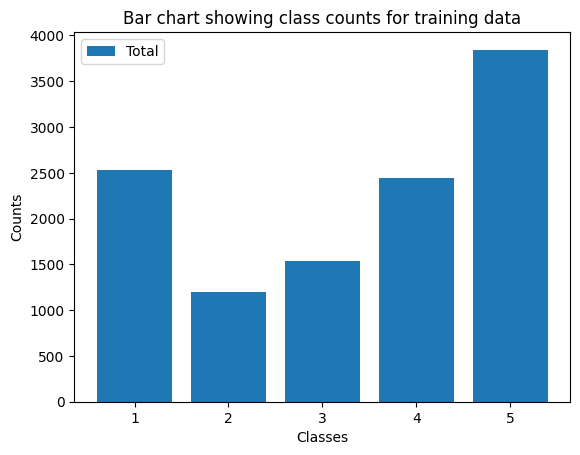

In [17]:
categories = [1,2,3,4,5]
total_values = totals_train

# Create a bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(categories, total_values, label='Total')

# Add labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Bar chart showing class counts for training data')
ax.legend()

# Show the plot
plt.show()

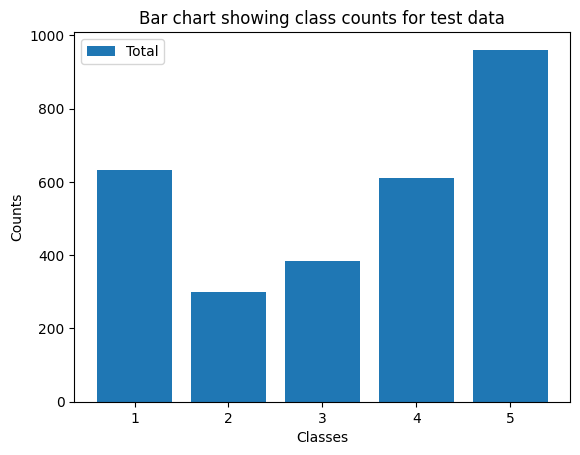

In [18]:
categories = [1,2,3,4,5]
total_values = totals_test

# Create a bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(categories, total_values, label='Total')

# Add labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Bar chart showing class counts for test data')
ax.legend()

# Show the plot
plt.show()

We can see that the training and test datasets are set up to have the exact same class distribution, which must necessarily match the overall distribution of classes in the whole combined dataset.

This distribution has significant class imbalance. Class 5, which represents general pathological conditions, is the largest. This is perhaps no surprise. It is the most 'general' class, so is likely to contain more examples.

The next two largest classes are 1 (neoplasms) and 4 (cardiovascular), followed by 3 (nervous system) and 2 (digestive system), the smallest class.

This class imbalance is not ideal for classification tasks, as methods will be dominated by the larger classes, and may cause some issues for our methods.

As a quick check, we examine how many of the data examples contain digits in their text. We do this as we will want to preprocess the data to take out special characters, but want to check whether numeric characters are more commonly found in certain classes. If this were the case, then if an abstract contained a digit, we would know which classes it is more likely to be from.

We define a function that detects whether a string contains any digit.

In [19]:
def contains_number(input_string):
    # Define a regular expression pattern to match any digit
    pattern = re.compile(r'\d')

    # Use the search method to check if the pattern is present in the input string
    match = re.search(pattern, input_string)

    # Return True if a match is found, indicating the presence of a number
    return bool(match)

Now we adapt our previous count function to count the data examples that contain digits.

In [22]:
def count_contains_digits(df):
  contains_number_sums = np.zeros(5, dtype=int)
  for i in range(len(df)):
    label, text = list(df.iloc[i])
    if contains_number(text):
      contains_number_sums[label-1] += 1
  return contains_number_sums

In [25]:
contains_digits_train = count_contains_digits(df_train)
contains_digits_test = count_contains_digits(df_test)

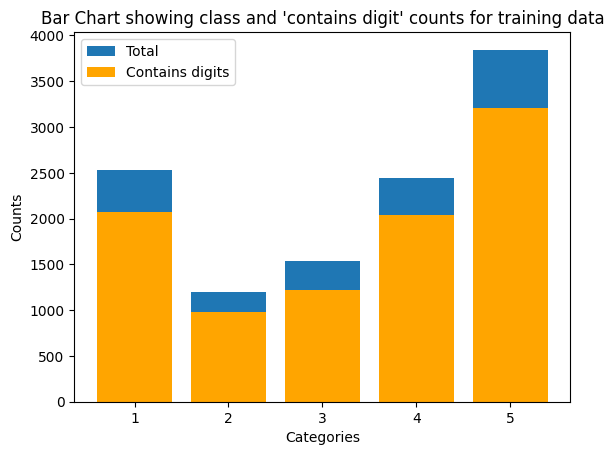

In [28]:
categories = [1,2,3,4,5]
x = 5
total_values = totals_train
condition_values = contains_digits_train

# Create a stacked bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(categories, total_values, label='Total')
bar2 = ax.bar(categories, condition_values, label='Contains digits', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.set_title("Bar Chart showing class and 'contains digit' counts for training data")
ax.legend()

# Show the plot
plt.show()

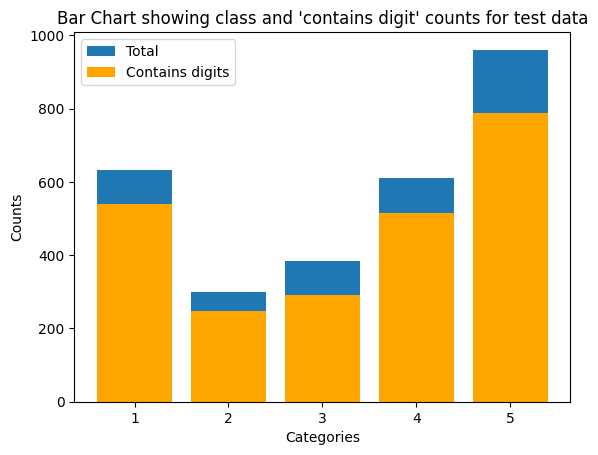

In [29]:
categories = [1,2,3,4,5]
x = 5
total_values = totals_test
condition_values = contains_digits_test

# Create a stacked bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(categories, total_values, label='Total')
bar2 = ax.bar(categories, condition_values, label='Contains digits', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.set_title("Bar Chart showing class and 'contains digit' counts for test data")
ax.legend()

# Show the plot
plt.show()

We see that all of the classes have a majority of data examples that contain digits, and so there is no information lost by removing words containing digits in our preprocessing.

# Preprocessing

Text preprocessing involves standardising text and discarding information that is not useful to our classifier. We examine an single medical abstract here as an example

(Note: run this code in Jupyter Notebooks not Google Colab to have the string print out over multiple lines, so it is more readable.)

In [38]:
sample_doc = df_train['medical_abstract'][1]
print(sample_doc)

Neuropeptide Y and neuron-specific enolase levels in benign and malignant pheochromocytomas. Neuron-specific enolase (NSE) is the isoform of enolase, a glycolytic enzyme found in the neuroendocrine system. Neuropeptide Y (NPY) is a peptide recently discovered in the peripheral and central nervous systems. Serum NSE and plasma NPY levels have been reported to be increased in some patients with pheochromocytoma. The authors evaluated whether the measurement of these molecules could help to discriminate between benign and malignant forms of pheochromocytoma. The NSE levels were normal in all patients with benign pheochromocytoma (n = 13) and elevated in one half of those with malignant pheochromocytoma (n = 13). Plasma NPY levels were on the average significantly higher in the malignant (177.1 +/- 38.9 pmol/l, n = 16) than in the benign forms of the disease (15.7 +/- 389 pmol/l, n = 24). However, there was no difference in the percentage of patients with elevated NPY levels. These results

The case of a character is not too relevant, so we make all characters lower case for simplicity.

In [39]:
sample_doc = sample_doc.lower()
print(sample_doc)

neuropeptide y and neuron-specific enolase levels in benign and malignant pheochromocytomas. neuron-specific enolase (nse) is the isoform of enolase, a glycolytic enzyme found in the neuroendocrine system. neuropeptide y (npy) is a peptide recently discovered in the peripheral and central nervous systems. serum nse and plasma npy levels have been reported to be increased in some patients with pheochromocytoma. the authors evaluated whether the measurement of these molecules could help to discriminate between benign and malignant forms of pheochromocytoma. the nse levels were normal in all patients with benign pheochromocytoma (n = 13) and elevated in one half of those with malignant pheochromocytoma (n = 13). plasma npy levels were on the average significantly higher in the malignant (177.1 +/- 38.9 pmol/l, n = 16) than in the benign forms of the disease (15.7 +/- 389 pmol/l, n = 24). however, there was no difference in the percentage of patients with elevated npy levels. these results

We tokenize the document so that we can work with individual words (tokens).

In [40]:
sample_doc = nltk.word_tokenize(sample_doc)
print(sample_doc)

['neuropeptide', 'y', 'and', 'neuron-specific', 'enolase', 'levels', 'in', 'benign', 'and', 'malignant', 'pheochromocytomas', '.', 'neuron-specific', 'enolase', '(', 'nse', ')', 'is', 'the', 'isoform', 'of', 'enolase', ',', 'a', 'glycolytic', 'enzyme', 'found', 'in', 'the', 'neuroendocrine', 'system', '.', 'neuropeptide', 'y', '(', 'npy', ')', 'is', 'a', 'peptide', 'recently', 'discovered', 'in', 'the', 'peripheral', 'and', 'central', 'nervous', 'systems', '.', 'serum', 'nse', 'and', 'plasma', 'npy', 'levels', 'have', 'been', 'reported', 'to', 'be', 'increased', 'in', 'some', 'patients', 'with', 'pheochromocytoma', '.', 'the', 'authors', 'evaluated', 'whether', 'the', 'measurement', 'of', 'these', 'molecules', 'could', 'help', 'to', 'discriminate', 'between', 'benign', 'and', 'malignant', 'forms', 'of', 'pheochromocytoma', '.', 'the', 'nse', 'levels', 'were', 'normal', 'in', 'all', 'patients', 'with', 'benign', 'pheochromocytoma', '(', 'n', '=', '13', ')', 'and', 'elevated', 'in', 'one

Numbers and special characters are not specific to classes (we have not examined other special characters but can assume this) and so to simplify things we remove all tokens that do not comprise solely of letters.

In [41]:
sample_doc = [tok for tok in sample_doc if re.match('^[a-zA-Z]+$', tok)]
print(sample_doc)

['neuropeptide', 'y', 'and', 'enolase', 'levels', 'in', 'benign', 'and', 'malignant', 'pheochromocytomas', 'enolase', 'nse', 'is', 'the', 'isoform', 'of', 'enolase', 'a', 'glycolytic', 'enzyme', 'found', 'in', 'the', 'neuroendocrine', 'system', 'neuropeptide', 'y', 'npy', 'is', 'a', 'peptide', 'recently', 'discovered', 'in', 'the', 'peripheral', 'and', 'central', 'nervous', 'systems', 'serum', 'nse', 'and', 'plasma', 'npy', 'levels', 'have', 'been', 'reported', 'to', 'be', 'increased', 'in', 'some', 'patients', 'with', 'pheochromocytoma', 'the', 'authors', 'evaluated', 'whether', 'the', 'measurement', 'of', 'these', 'molecules', 'could', 'help', 'to', 'discriminate', 'between', 'benign', 'and', 'malignant', 'forms', 'of', 'pheochromocytoma', 'the', 'nse', 'levels', 'were', 'normal', 'in', 'all', 'patients', 'with', 'benign', 'pheochromocytoma', 'n', 'and', 'elevated', 'in', 'one', 'half', 'of', 'those', 'with', 'malignant', 'pheochromocytoma', 'n', 'plasma', 'npy', 'levels', 'were', 'o

Tokens of length 1 are now either words of length 1 (not class specific) or a product of our previous steps (artificial/not words) - in both cases we can remove them.

In [42]:
sample_doc = [tok for tok in sample_doc if len(tok) > 1]
print(sample_doc)

['neuropeptide', 'and', 'enolase', 'levels', 'in', 'benign', 'and', 'malignant', 'pheochromocytomas', 'enolase', 'nse', 'is', 'the', 'isoform', 'of', 'enolase', 'glycolytic', 'enzyme', 'found', 'in', 'the', 'neuroendocrine', 'system', 'neuropeptide', 'npy', 'is', 'peptide', 'recently', 'discovered', 'in', 'the', 'peripheral', 'and', 'central', 'nervous', 'systems', 'serum', 'nse', 'and', 'plasma', 'npy', 'levels', 'have', 'been', 'reported', 'to', 'be', 'increased', 'in', 'some', 'patients', 'with', 'pheochromocytoma', 'the', 'authors', 'evaluated', 'whether', 'the', 'measurement', 'of', 'these', 'molecules', 'could', 'help', 'to', 'discriminate', 'between', 'benign', 'and', 'malignant', 'forms', 'of', 'pheochromocytoma', 'the', 'nse', 'levels', 'were', 'normal', 'in', 'all', 'patients', 'with', 'benign', 'pheochromocytoma', 'and', 'elevated', 'in', 'one', 'half', 'of', 'those', 'with', 'malignant', 'pheochromocytoma', 'plasma', 'npy', 'levels', 'were', 'on', 'the', 'average', 'signifi

We now remove stopwords as they are unlikely to carry information about the class.

In [43]:
sample_doc = [tok for tok in sample_doc if tok not in en_stop]
print(sample_doc)

['neuropeptide', 'enolase', 'levels', 'benign', 'malignant', 'pheochromocytomas', 'enolase', 'nse', 'isoform', 'enolase', 'glycolytic', 'enzyme', 'found', 'neuroendocrine', 'system', 'neuropeptide', 'npy', 'peptide', 'recently', 'discovered', 'peripheral', 'central', 'nervous', 'systems', 'serum', 'nse', 'plasma', 'npy', 'levels', 'reported', 'increased', 'patients', 'pheochromocytoma', 'authors', 'evaluated', 'whether', 'measurement', 'molecules', 'could', 'help', 'discriminate', 'benign', 'malignant', 'forms', 'pheochromocytoma', 'nse', 'levels', 'normal', 'patients', 'benign', 'pheochromocytoma', 'elevated', 'one', 'half', 'malignant', 'pheochromocytoma', 'plasma', 'npy', 'levels', 'average', 'significantly', 'higher', 'malignant', 'benign', 'forms', 'disease', 'however', 'difference', 'percentage', 'patients', 'elevated', 'npy', 'levels', 'results', 'show', 'determination', 'serum', 'nse', 'may', 'useful', 'distinguishing', 'malignant', 'benign', 'pheochromocytoma', 'measurement', 

Now we lemmatize: this reduces words to their basic form.

In [44]:
lemmatizer = WordNetLemmatizer()
sample_doc = [lemmatizer.lemmatize(tok) for tok in sample_doc]
print(sample_doc)

['neuropeptide', 'enolase', 'level', 'benign', 'malignant', 'pheochromocytoma', 'enolase', 'nse', 'isoform', 'enolase', 'glycolytic', 'enzyme', 'found', 'neuroendocrine', 'system', 'neuropeptide', 'npy', 'peptide', 'recently', 'discovered', 'peripheral', 'central', 'nervous', 'system', 'serum', 'nse', 'plasma', 'npy', 'level', 'reported', 'increased', 'patient', 'pheochromocytoma', 'author', 'evaluated', 'whether', 'measurement', 'molecule', 'could', 'help', 'discriminate', 'benign', 'malignant', 'form', 'pheochromocytoma', 'nse', 'level', 'normal', 'patient', 'benign', 'pheochromocytoma', 'elevated', 'one', 'half', 'malignant', 'pheochromocytoma', 'plasma', 'npy', 'level', 'average', 'significantly', 'higher', 'malignant', 'benign', 'form', 'disease', 'however', 'difference', 'percentage', 'patient', 'elevated', 'npy', 'level', 'result', 'show', 'determination', 'serum', 'nse', 'may', 'useful', 'distinguishing', 'malignant', 'benign', 'pheochromocytoma', 'measurement', 'plasma', 'npy'

Now we can create a function that applies all of these techniques to a document.

In [45]:
def preprocess(doc):
  #lowercases document
  doc = doc.lower()
  #tokenize
  toks = nltk.word_tokenize(doc)
  #remove tokens that don't exclusively contain letters
  toks = [tok for tok in toks if re.match('^[a-zA-Z]+$', tok)]
  #remove tokens of lenth <= n (can be varied)
  toks = [tok for tok in toks if len(tok) > 1]
  #remove stopwords
  toks = [tok for tok in toks if tok not in en_stop]
  #lemmatize
  toks = [WordNetLemmatizer().lemmatize(tok) for tok in toks]
  return toks

In [46]:
sample_doc0 = df_train['medical_abstract'][1]
sample_doc0 = preprocess(sample_doc0)
print(sample_doc0)

['neuropeptide', 'enolase', 'level', 'benign', 'malignant', 'pheochromocytoma', 'enolase', 'nse', 'isoform', 'enolase', 'glycolytic', 'enzyme', 'found', 'neuroendocrine', 'system', 'neuropeptide', 'npy', 'peptide', 'recently', 'discovered', 'peripheral', 'central', 'nervous', 'system', 'serum', 'nse', 'plasma', 'npy', 'level', 'reported', 'increased', 'patient', 'pheochromocytoma', 'author', 'evaluated', 'whether', 'measurement', 'molecule', 'could', 'help', 'discriminate', 'benign', 'malignant', 'form', 'pheochromocytoma', 'nse', 'level', 'normal', 'patient', 'benign', 'pheochromocytoma', 'elevated', 'one', 'half', 'malignant', 'pheochromocytoma', 'plasma', 'npy', 'level', 'average', 'significantly', 'higher', 'malignant', 'benign', 'form', 'disease', 'however', 'difference', 'percentage', 'patient', 'elevated', 'npy', 'level', 'result', 'show', 'determination', 'serum', 'nse', 'may', 'useful', 'distinguishing', 'malignant', 'benign', 'pheochromocytoma', 'measurement', 'plasma', 'npy'

As noted in one of the comments, we can also consider removing tokens of length <= n, where n is more than 1. This is because some of the most useful words (especially for this medical context) will likely be longer.